In [20]:
#Packages
# This code is a lighter version of the previous code with no calculation of 
# eigenvalues
import os
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
from copy import deepcopy

from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals


In [21]:
# Function to call Praful's code, returning an Excel file with the cores identified
# Ne trouve pas de core pour le cas n=2 (type I)
def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

In [22]:
#S = np.array([[-2,  2, -1,  1, -1,  1, -1,  1, -1,  1,  0,  0,  0,  0],
#       [ 1, -1, -1,  1,  0,  0,  1, -1,  2, -2, -2,  2, -1,  1],
#       [ 0,  0,  1, -1, -1,  1,  1, -1, -1,  1,  0,  0,  2, -2],
#       [ 0,  0,  0,  0,  1, -1, -1,  1,  0,  0,  1, -1, -1,  1]])
#auto(S,4)

In [23]:
S = np.array([[1,  -1, 0, 0,  -1, -1],
             [ 0, 0, -1, 1, 1, -1],
             [-2, 2, 1, -1, 1, -1]])
auto(S,3)

#Species:  3 # Reactions:  6
#Species:  3 # Reactions:  6
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx


In [24]:
S = np.array([[-1,  0, 1],
              [1, -1, 1],
       [ 0, 1, -1]])
auto(S,3)

#Species:  3 # Reactions:  3
#Species:  3 # Reactions:  3
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C', 'C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R2', 'R3']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R1: C ->C_2
			 R2: C_2 ->C_3
			 R3: C_3 ->C+C_2
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 1
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx


In [25]:
#Function to find the cores and print them. The function also rearrange the cores into Metzler matrices to check their positive unstability

def stoichio(data, SM, N_Y, N_RY, reverse):
    
    matrices = [] # List of cores that will be found

    SM = np.array(SM)
    
    for index, riga in data.iloc[1:].iterrows(): # Spanning among the rows of the Excel file (the rows are the autocatalytic cores)
        indices_N_Y = [i for i, valore in enumerate(riga[(2 + N_Y):(2 + 2*N_Y)]) if valore == 1]   # Save the species that belong to the core
        indices_N_RY = [i for i, valore in enumerate(riga[(2 + 2*N_Y):(2 + 2*N_Y + N_RY + len(reverse))]) if valore == 1]   # Save the reactions that belong to the core
        
        submatrix = SM[np.ix_(indices_N_Y, indices_N_RY)]

        matrices.append(submatrix) # Append all the cores together

#    max_eigenvalues = [] # List for the maximum eigenvalues for each core (list of scalars)
#    lambs = [] # List for all the eigenvalues of all the cores (list of lists)
    
#    print(f"Eigenvalues for the {len(matrices)} cores:\n")

    def is_metzler(matrix): # Function that check that the core is indeed already rearranged into a Metzler matrix
   
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if i != j and matrix[i, j] < 0:
                    return False
        return True

    def permute_to_metzler(matrix): # Function that transforms the core into a Metzler matrix if it was not
       
        n = matrix.shape[0]
        row_indices = list(range(n))
        
        for perm in itertools.permutations(row_indices):
            permuted_matrix = matrix[list(perm), :]
            if is_metzler(permuted_matrix):
                return permuted_matrix
        return None

    return matrices 

In [26]:
# Function to compute a "confusion matrix" to check the percentage of autocatalytic systems which survived among the total number

def confusion(autocatalytics, survival):
    
    auto = [int(x) for x in autocatalytics]   # Takes the outputs of the function "invasion" (cell below) and transform it into boolean variables
    surv = [int(x) for x in survival]

    num_auto = sum(auto) # Total number of autocatalytic realizations
    num_surviving_auto = sum([1 for a, s in zip(auto, surv) if a == 1 and s == 1]) # Total number of surviving AND autocatalytic
    num_non_auto = len(auto) - num_auto # Non autocatalytic realizations
    num_surviving_non_auto = sum([1 for a, s in zip(auto, surv) if a == 0 and s == 1]) # Total number of surviving AND NOT autocatalytic

    
    data = {
        'Category': ['Auto', 'Non-Auto'],
        'Non-Surviving Processes': [num_auto, num_non_auto],                         # Labels for the confusion matrix
        'Surviving Processes': [num_surviving_auto, num_surviving_non_auto]
    }
    
    df = pd.DataFrame(data) # Table in pd

    #Plotting the histogram
    
 #   plt.figure(figsize=(8, 6))
 #   sns.barplot(x='Category', y='Non-Surviving Processes', data=df, color='green', label='Non-Surviving')
 #   sns.barplot(x='Category', y='Surviving Processes', data=df, color='yellow', label='Surviving')
 #   plt.title('Histogram for autocatalysis and surviving',fontsize = 25, pad = 20)
 #   plt.xlabel('')
 #   plt.ylabel('Number of realizations', fontsize = 30)
 #   plt.xticks(fontsize=30)  
 #   plt.yticks(fontsize=30)  
 #   plt.legend(fontsize=25)  
 #   plt.tight_layout()

    # Saving the image in output
    os.makedirs('./output/images/', exist_ok=True)
 #   plt.savefig('./output/images/confusion_matrix_large.pdf', dpi=300)

 #   plt.show()


    return df


In [27]:
# Main function to check autocatalysis and run simulations  (THE OLDEST VERSION) THERMODYNAMIC CONSTRAINT

def invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy):
    
    # Number of steps
    npas = int(ttot / dt)
    cores_number = []
    
    # Inizialization of compt
    compt = 0
    temps = 0
    
    autocatalytics = []
    survival = []

    # Coherency between reactions
    
    if diluted == True and autonomy == False:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return autocatalytics, survival

    # Delete the previous output

    [shutil.rmtree(os.path.join('output', f)) if os.path.isdir(os.path.join('output', f)) else os.unlink(os.path.join('output', f)) for f in os.listdir('output')]
    
    
    for r in range(REALIZATIONS):

        resY = open("output/Time_%d.dat"%(r + 1), "w")
        resSp = open("output/Stoichio_%d.dat"%(r + 1), "w")

        resY.truncate(0)
        resSp.truncate(0)
    
        S = np.zeros((N_X + N_Y, N_RY))
        # Stoichiometric matrix of the invaders' reactions and for all the species (forward processes)
        S1 = np.zeros((N_X + N_Y, N_RY))
        # Stoichiometric matrix of the invaders' reactions and for all the species (reverse processes)

        # S is the forward matrix (S+) and S1 is the reverse one (S-)
        
        
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)] # Initialize constant values for the original species
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)] # Initialize constant values for the invader species
    
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)] # Initialize constant values for the forward rates
        mu_0 = [random.uniform(-1, 1) for _ in range(N_Y)] # For the thermodynamical feasibility of the reactions
        #kr = [random.uniform(0.95, 1.05) for _ in range(N_RY)] # Initialize constant values for the backward rates

        Ytot = sum(Y)

    
        for i in range(N_RY):
                
            total_order_for = random.randint(0, 2)  # Total order for the forward
            total_order_bac = random.randint(0, 2)  # Total order for the backward
            stoichio_for = 0
            stoichio_bac = 0

            
            species1 = random.randint(0, N_Y-1) # There must be at least one Y as reactant
            S[N_X + species1][i] += 1
            

            # Setting the necessary reactants and products due to AUTONOMY

            if autonomy == True: # ONLY IF WE HAVE AUTONOMY THERE MUST BE AT LEAST ONE Y AS PRODUCT
                
                species2 = random.randint(0, N_Y-1)
                
                if ambiguity == False: # ONLY IF THERE IS NO AMBIGUITY I HAVE TO CHECK THE PRODUCT IS NOT THE SAME AS THE REACTANT
                    while species2 == species1:
                        species2 = random.randint(0, N_Y-1) # Non-ambiguity condition
                        
                S1[N_X + species2][i] += 1    # There must be at least one Y as product
                


            # Setting the REACTANTS depending on DILUTION and AMBIGUITY
        
            while(stoichio_for < total_order_for - 1): # Constructing the stoichio forward matrix randomly, up to a total order

                # If there is dilution I can have just a single Y reactant, that I already took, so I can only sample from the X's
                if diluted == False:
                    species = random.randint(0, N_X + N_Y - 1)
                else:
                    species = random.randint(0, N_X  - 1)
                    
                # If there is non-ambiguity I have to be sure the species is not a product already
                if ambiguity == False:
                    if S1[species][i] == 0:  # Non ambiguity
                        S[species][i] += 1
                        stoichio_for += 1
                else:
                    S[species][i] += 1
                    stoichio_for += 1
                    
            # Setting the PRODUCTS depending on DILUTION, AMBIGUITY and AUTONOMY
    
            while(stoichio_bac < (total_order_bac - 1 if autonomy else total_order_bac)): # Costructing the stoichio forward matrix randomly, up to a total order that changes depending on the assumption on autonomy
    
                species = random.randint(0, N_X + N_Y - 1)

                # If there is non-ambiguity I have to be sure the species is not a reactant already
                if ambiguity == False:
                    if S[species][i] == 0:  # Non ambiguity
                        S1[species][i] += 1
                        stoichio_bac += 1
                else:
                    S1[species][i] += 1
                    stoichio_bac += 1
                    
    
        # AUTOCATALYSIS CHECKING
        # Preparing the input for Praful's code splitting the reactions in backward and forward

        
        # Matrix of the invaders and the total one

        #S1 = np.array([[0, 1, 1, 0, 0, 0, 1, 0],
         #   [1, 0, 1, 0, 1, 0, 0, 1],
         #   [0, 0, 0, 1, 0, 1, 1, 0]])

        #S = np.array([[1, 0, 0, 1, 0, 0, 0, 1],
         #   [0, 1, 0, 1, 0, 0, 1, 0],
          #  [0, 0, 1, 0, 1, 0, 0, 1]])
        
        
        Sp = (S1 - S)[N_X:][:]
        Stot = S1 - S

        # List of new columns to be inverted for the reversible reactions, for the invaders and the whole community
        new_sp_col = []
        new_stot_col = []

        # List of index of the reaction that will be taken as reversible in the OLD and NEW Sp
        reverse = []
        reverse_indices = []
        
        #This loop will invert the columns whenever the system is not diluted AND the reaction is not of the type Y->0 or it will invert if the system is diluted AND the number of Y products is lower than 2 (TOP conditions)
        for index, (sp_col, stot_col, s1_col) in enumerate(zip(Sp.T, Stot.T, S1[N_X:][:].T)):
            if (not diluted and sum(value for value in s1_col if value > 0) >= 1) or (diluted and sum(value for value in s1_col if value > 0) < 2):
                new_sp_col.extend([sp_col, -sp_col])
                new_stot_col.extend([stot_col, -stot_col])
                reverse.append(index)  # Save the index of the reversible reactions
                reverse_indices.extend([len(new_sp_col) - 2]) # Same but for the new matrix, needed to estabilish the thermodynamical constraint
            else:
                new_sp_col.append(sp_col)
                new_stot_col.append(stot_col)      

        # Creating the new matrices with added reactions that represents the reversible ones, following the constraints explained above
        Sp = np.column_stack(new_sp_col).astype(int)
        Stot = np.column_stack(new_stot_col).astype(int)

        
        #print(reverse)
        #print(reverse_indices)

        
        #Thermodynamical constraint
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        S_reversible = Sp[:, reverse_indices]
        DeltaG0 = np.dot(S_reversible.T, mu_0_vector).flatten()

        kf_reversible = np.array([kf[i] for i in reverse])
        kr_reversible = kf_reversible * np.exp(DeltaG0)  

        kr = np.zeros(len(kf))
        kr[reverse] = kr_reversible
        
        auto(Sp, N_Y) # Calling Praful's program on the new invaders matrix
        data = pd.read_excel("output/AC_n%d.xlsx"%(N_Y), header = None) 
    
        if  len(data.iloc[:][0]) > 1:    # Checking the existance of AT LEAST a core in the invaders matrix from the excel output file
    
            print("INVADERS SHOW AUTOCATALYSIS \n \n")

            matrices = stoichio(data, Sp, N_Y, N_RY, reverse) # This will print (not in the file) the eigenvalues of every core found!

            cores_number.append(len(matrices))
            
            resSp.write('SHOWS AUTOCATALYSIS \n')
    
            autocatalytics.append(True)
    
        else:
    
            print("NO AUTOCATALYTIC BEHAVIOR \n \n")

            cores_number.append(0)
            
            resSp.write("DOESN'T SHOW AUTOCATALYSIS \n")
    
            autocatalytics.append(False)
            
        
        for i in range(npas//100): # Two timescales to print not too much
            
            temps = (i * 100) * dt
            
            print(f"{round(temps,1)} {round(Ytot,3)} ", file=resY)
            
            for j in range(100):
                
                curr = np.zeros(N_RY)

                
                # If I have MAL, I update the currents each iteration, ONLY REVERSED ONE WILL HAVE THE BACKWARD CURRENT, THIS MUST BE DONE BECAUSE S AND S1 ARE A PRIORI FROM THE REVERSIBILITY
                if law == "MAL":

                    ratef = kf[:]
                    rater = deepcopy(kr)
                    
                    for l in range(N_RY):
                        
                        for s, p in zip(np.concatenate((X,Y)), S[:,l]):  # Updating the currents for each reaction each time step
                            ratef[l] *= pow(s, p)
                        for s, p in zip(np.concatenate((X,Y)), S1[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)   
                        if l in reverse:
                            curr[l] = np.array(ratef[l]) - np.array(rater[l])
                        else:
                            curr[l] = np.array(ratef[l])
                            

                # If I have MM, the forward rate will change, the backward will still be MAL
                if law == "MM":

                    ratef = np.ones(len(kf[:]))
                    rater = deepcopy(kr)

                    for l in range(N_RY):
                        
                        prod = 1
                        
                        for s, p in zip(np.concatenate((X,Y)), S[:,l]):  # Updating the currents for each reaction each time step
                            prod *= pow(s, p)
                        ratef[l] = prod/(kf[l] + prod)
                       
                        for s, p in zip(np.concatenate((X,Y)), S1[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)  

                        if l in reverse:
                            curr[l] = np.array(ratef[l]) - np.array(rater[l])
                        else:
                            curr[l] = np.array(ratef[l])
                    
                    

                # ODE 
                Y += dt * np.dot((S1 - S)[N_X:][:], np.array(curr))   # Solving a timestep ODE for the vector of invaders
                Y[Y < 0] = 0 # Non-negativity condition
                
                Ytot = sum(Y)
                
        resSp.write('\n')
        np.savetxt(resSp, Sp, fmt='%d', delimiter=' ', header='', comments='')     # Printing the INVADERS survival matrix in "Stoichio_matrix_Y"
        resSp.write('\n \n')
        np.savetxt(resSp, Stot, fmt='%d', delimiter=' ', header='', comments='') # Printing the WHOLE survival matrix in "Stoichio_matrix_Y"
    
        
        if Ytot >= 0.2: # Threshold for survival
            compt += 1
            
            resSp.write("\n")
            resSp.write('INVADERS GREW')
            
    
            survival.append(True)
    
        else: 
            resSp.write("\n")
            resSp.write("INVADERS DIDN'T GROW")
    
            survival.append(False)


        # Printing all the cores in the stoichio file, if there was autocatalysis, for such a realization
        if  len(data.iloc[:][0]) > 1:
            
            resSp.write('\n\n\n CORES:\n')
            for i in range(len(matrices)):
                np.savetxt(resSp, matrices[i], fmt='%d', delimiter=' ', header='', comments='')
                resSp.write('\n')
            
        resSp.close()
        resY.close()      # Saving and closing the open files
    
    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")

    return autocatalytics, survival, cores_number

In [28]:
#Parameters definition

ttot = float(100.0) # Total time for the simulation
dt = 1.0E-3 # Timestep

npas = int(ttot//dt)

REALIZATIONS = 5
# Number of simulations

N_X = 3  # Number of species in the original dynamic system
#N_RX = 2  # Number of reactions in the original systems (NOT NEEDED IF X's ARE CONSTANTS)

N_Y = 3  # Number of invaders (must be higher than 3, otherwise I can end up with ambiguity)
N_RY = 4  # Number of reactions for the invaders

In [29]:
# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. Saving also the list of max eigenvs and cores number

autocatalytics,survival,cores_number = invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted = False, ambiguity = False, law = "MAL", autonomy = True)

#Species:  3 # Reactions:  8
#Species:  3 # Reactions:  8
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C', 'C_2']
	 Reactions in AC:  ['R1', 'R6']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_2 ->2C
			 R6: C ->C_2
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C', 'C_2', 'C_3']
	 Reactions in AC:  ['R1', 'R3', 'R8']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R1: C_2 ->2C
			 R3: C_3 ->C_2
			 R8: C ->C_3
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 2
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
INVADERS SHOW AUTOCATALYSIS 
 

#Species:  3 # Reactions:  8
#Species:  3 # Reactions:  8
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 

In [30]:
# Histogram of autos and survivals

confusion(autocatalytics, survival)

,Category,Non-Surviving Processes,Surviving Processes
0,Auto,3,3
1,Non-Auto,2,0


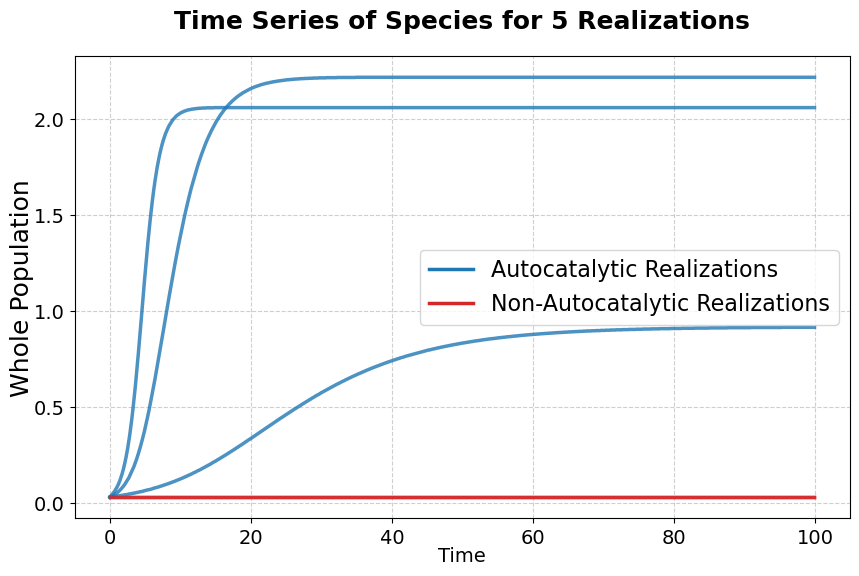

In [31]:
# Specify the folder where to take data
folder_path = "output"

# Finding "Time_" files and sort them
file_list = glob.glob(os.path.join(folder_path, "Time_*"))
file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

# Create a figure with the desired size
plt.figure(figsize=(10, 6))

# Plotting the files based on their autocatalysis
for file, autocatalytic in zip(file_list, autocatalytics):
    
    # Read the data file
    data = pd.read_csv(file, delimiter='\s+', header=None, names=['Time', 'Conc'])

    # Choose color based on autocatalysis
    color = '#1f77b4' if autocatalytic else '#d62728'  # Blue for autocatalytic, red for non-autocatalytic
    
    # Plot each realization with a smooth and elegant line
    plt.plot(data['Time'], data['Conc'], color=color, linewidth=2.5, alpha=0.8)

# Adding the threshold line (optional)
# plt.axhline(y=0.2, color='green', linestyle='--', label='Threshold 0.2')

# Adding title and labels with the desired font size
plt.title('Time Series of Species for %d Realizations' % REALIZATIONS, fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14, labelpad=0)
plt.ylabel('Whole Population', fontsize=18, labelpad=0)

# Customize ticks for better aesthetics
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding a legend for autocatalytic and non-autocatalytic realizations
legend_elements = [
    Line2D([0], [0], color='#1f77b4', lw=2.5, label='Autocatalytic Realizations'),
    Line2D([0], [0], color='#d62728', lw=2.5, label='Non-Autocatalytic Realizations'),
]
plt.legend(handles=legend_elements, loc='best', fontsize=16)

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

#plt.xlim(-0.1,30)

# Saving the figure in high resolution
plt.savefig("./output/images/traj.pdf", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()
